<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Seq2Seq_translation_final_scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sources:**

Baseline - [Pytorch tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial)

Embeddings -https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

https://python-school.ru/blog/word2vec-with-examples-in-gensim/

Dataloader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

Self attention and pad_packed_sequence https://discuss.pytorch.org/t/self-attention-on-words-and-masking/5671

https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html

scheduler https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In this notebook I try to use scheduler:
1. **I choose scheduler**, which can change learning rate due to loss result. It check loss changes during the training and make step if loss stop to improve.

*torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)*

It has lots of configurable parametrs.


In [1]:
import pandas as pd
import numpy as np
#from sklearn.model_selection import train_test_split


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import tqdm
from tqdm import tqdm

In [3]:
import unicodedata
import string
import re
import random
import itertools

In [4]:
import time
import math
from collections import defaultdict

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [6]:
import os
from pathlib import Path
import sys

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Mounted at /content/drive


In [8]:
from preprocessing import prepareData, readLangs, tensorsFromPair, tensorFromSentence

In [ ]:
SOS_token = 1
EOS_token = 0

In [9]:
config = {  
    'path'  :'/content/drive/MyDrive/NLP_translation/old_slav.txt', #old slavenic - rus
    #'path':'/content/rus.txt', #rus-eng
    'MAX_LENGTH':20,
    'reverse':True,
    'pad_index':[0,1],
    
    'batch_size':8, # for short datasets use batch_size - 8, for big dataset - 256

    'teacher_forcing_ratio': 0.5,
    'hidden_size':256,
    'num_epochs':100,
    
    'lr': 0.001
}

In [10]:
from model import EncoderRNN, AttnDecoderRNN, TONModel

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', config['path'], config['MAX_LENGTH'], config['reverse'])
print(random.choice(train_pairs))

Reading lines...


100%|██████████| 229/229 [00:00<00:00, 596951.91it/s]

Read 159 sentence pairs train
Read 69 sentence pairs test
Trimmed to 159 sentence train pairs
Trimmed to 69 sentence test pairs
Counting words...
Counted words train:
old_rus 776
new_rus 744
Counted words test:
old_rus 359
new_rus 341
['аще не можете даромъ', 'если не можете (почтить) подарком ']


Check lengths of sentences

In [13]:
#max length of train sentence
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[24, 25]

In [ ]:
#max length of test sentence
max([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)

[20, 24]

In [ ]:
def len_pair(pair):
  len_0=len(pair[0].split(' '))
  len_1=len(pair[1].split(' '))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

Plot histogramm for length of source sentence

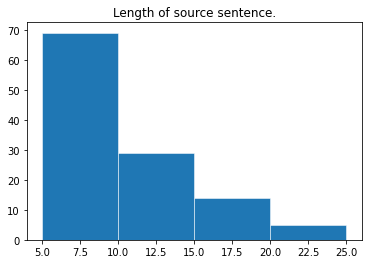

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



Plot histogramm for length of target sentence

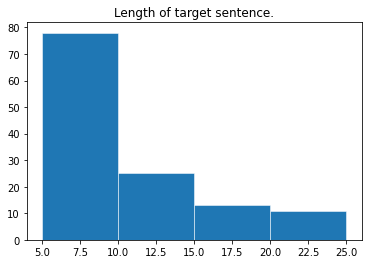

In [ ]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Make DataLoaders for train and test sentences.

For use dataloader I add padding sentences to max length in tensorFromSentence. 
To use pad_packed_sentence I add get_len function to get true length of sentence.

In [14]:
training_pairs = [tensorsFromPair(train_pair, train_input_lang, train_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for train_pair in tqdm(train_pairs)]
testing_pairs = [tensorsFromPair(test_pair, test_input_lang, test_output_lang, MAX_LENGTH=config['MAX_LENGTH'])
                      for test_pair in tqdm(test_pairs)]
train_loader = torch.utils.data.DataLoader(training_pairs, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_pairs, batch_size=config['batch_size'], shuffle=False)   #Test dataloader without shuffling pairs to have comparable results for validation loop                                         

100%|██████████| 69/69 [00:00<00:00, 14695.93it/s]


Make helper functions.

In [15]:
#function to check time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
#function to plot loss curves
def plot_learning_curves(history):
    sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(10,5))

    # plt.subplot(1,3,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

Create a traning model using dataloader.
Made changes: 
1. epoch iteration. Each epoch is train on all train dataset and validate on test dataset.
2. Encoder and decoder comunication is in model. In training model function I just pass input tensor, output tensor and input sentence length into model and get decoder output out.
3. I use batches to load data, so outputs and target have to be transformed to pass to loss function.
4. I collect train and validation loss for each epoch into defaultdict.
5. I plot train and validation loss after the training.
6. I save best model during the training.

In [23]:
#model with data loader
def train_modelIters(model, optimizer, loader, test_loader, criterion, num_epochs=6, scheduler=None):
    start = time.time() #start time
    itog_losses = []
    best_loss=np.inf #initiate best loss to check and save model with best loss.

    history = defaultdict(lambda: defaultdict(list))  #dictionry to collect losses  
      
    for epoch in tqdm(range(num_epochs), desc='epochs'):
      model.train(True)      

      plot_losses = []
      #print_loss_total = 0  
      plot_loss_total = 0

      val_losses = []
      val_loss_total = 0  
      
      #train loop
      for batch in tqdm(loader, desc='train sample batches'):
          
          input_tensor = batch[0].to(device)
          input_len=batch[1]          #true length  of sentences in batches withput padding
          target_tensor = batch[2].to(device)                           
         
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0])
          
          target_tensor = target_tensor.view(-1) #change dimantion in one size
          output_dim = decoder_outputs.shape[-1]  #change dimantion in one size
          decoder_outputs=decoder_outputs.view(-1, output_dim)  #change dimantion in one size
          
          loss = criterion(decoder_outputs, target_tensor)      #calculate loss
          
          loss.backward(retain_graph=True)    
          optimizer.step()
          optimizer.zero_grad()                   
          
          plot_loss_total += loss.item() #collect losses
          
      plot_loss_avg = plot_loss_total /  len(loader)
      history['loss']['train'].append(plot_loss_avg)
      
      model.train(False)
      #validation loop
      for batch in tqdm(test_loader, desc='validation sample batches'):
        
        input_tensor = batch[0].to(device)
        input_len=batch[1]
        target_tensor = batch[2].to(device)
               
        with torch.no_grad():
          decoder_outputs, _ = model(input_tensor[:,:,0], input_len, target_tensor[:,:,0],
                                  evalute=True)
          
          target_tensor = target_tensor.view(-1)
          output_dim = decoder_outputs.shape[-1]            
          decoder_outputs=decoder_outputs.view(-1, output_dim)    
          
          val_loss = criterion(decoder_outputs, target_tensor) # calculate validation loss          
          val_loss_total+= loss.item() #collect loss item
          if scheduler!=None:
            scheduler.step(val_loss)

      val_loss_avg = val_loss_total / len(test_loader)    
      history['loss']['val'].append(val_loss_avg)
      print('Epoch train loss', plot_loss_avg, end='\n')
      print('Epoch val_loss', val_loss_avg, end='\n')

      if val_loss_avg<best_loss: #save best model
        best_loss=val_loss
        torch.save(model, 'best_model.pt')

    plot_learning_curves(history) #plot loss curves
    return 

Train model using Adam optimizer, NLLLos and scheduler

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:   1%|          | 1/100 [00:04<07:13,  4.38s/it]

Epoch train loss 6.088782000541687
Epoch val_loss 6.203424453735352



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.17it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.56it/s]

Epoch 00012: reducing learning rate of group 0 to 9.5000e-04.



epochs:   2%|▏         | 2/100 [00:08<07:04,  4.34s/it]

Epoch train loss 5.468024754524231
Epoch val_loss 5.326562404632568



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 24.06it/s]

Epoch 00023: reducing learning rate of group 0 to 9.0250e-04.
Epoch train loss 5.101733994483948
Epoch val_loss 5.233353137969971



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]

epochs:   4%|▍         | 4/100 [00:17<06:57,  4.35s/it]

Epoch 00034: reducing learning rate of group 0 to 8.5737e-04.
Epoch train loss 4.75150351524353
Epoch val_loss 4.980801105499268



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

epochs:   5%|▌         | 5/100 [00:21<06:49,  4.31s/it]

Epoch 00045: reducing learning rate of group 0 to 8.1451e-04.
Epoch train loss 4.417008376121521
Epoch val_loss 4.585211753845215



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:   6%|▌         | 6/100 [00:26<06:48,  4.35s/it]

Epoch train loss 3.9968854069709776
Epoch val_loss 3.630803346633911



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 24.50it/s]

Epoch 00056: reducing learning rate of group 0 to 7.7378e-04.



epochs:   7%|▋         | 7/100 [00:30<06:45,  4.36s/it]

Epoch train loss 3.605723762512207
Epoch val_loss 3.4967567920684814



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 22.11it/s]

Epoch 00067: reducing learning rate of group 0 to 7.3509e-04.


epochs:   8%|▊         | 8/100 [00:34<06:43,  4.38s/it]

Epoch train loss 3.271369743347168
Epoch val_loss 3.571030855178833



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:   9%|▉         | 9/100 [00:39<06:37,  4.37s/it]

Epoch 00078: reducing learning rate of group 0 to 6.9834e-04.
Epoch train loss 2.9358998417854307
Epoch val_loss 2.9917938709259033



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  10%|█         | 10/100 [00:43<06:35,  4.39s/it]

Epoch 00089: reducing learning rate of group 0 to 6.6342e-04.
Epoch train loss 2.674825572967529
Epoch val_loss 2.7365729808807373



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  11%|█         | 11/100 [00:48<06:30,  4.39s/it]

Epoch train loss 2.482600510120392
Epoch val_loss 2.316967487335205



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 29.08it/s]

Epoch 00100: reducing learning rate of group 0 to 6.3025e-04.



epochs:  12%|█▏        | 12/100 [00:52<06:23,  4.36s/it]

Epoch train loss 2.3240412414073943
Epoch val_loss 2.454646348953247



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.88it/s]

Epoch 00111: reducing learning rate of group 0 to 5.9874e-04.



epochs:  13%|█▎        | 13/100 [00:56<06:21,  4.38s/it]

Epoch train loss 2.166200202703476
Epoch val_loss 2.4113762378692627



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

epochs:  14%|█▍        | 14/100 [01:01<06:14,  4.36s/it]

Epoch 00122: reducing learning rate of group 0 to 5.6880e-04.
Epoch train loss 2.0272664368152618
Epoch val_loss 2.227379560470581



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.10it/s]

epochs:  15%|█▌        | 15/100 [01:05<06:09,  4.34s/it]

Epoch 00133: reducing learning rate of group 0 to 5.4036e-04.
Epoch train loss 2.0131288886070253
Epoch val_loss 2.0568079948425293



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

epochs:  16%|█▌        | 16/100 [01:09<06:06,  4.36s/it]

Epoch 00144: reducing learning rate of group 0 to 5.1334e-04.
Epoch train loss 1.9519098281860352
Epoch val_loss 2.0643372535705566



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  17%|█▋        | 17/100 [01:14<06:04,  4.39s/it]

Epoch train loss 1.8438119113445282
Epoch val_loss 2.0126073360443115



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.86it/s]

Epoch 00155: reducing learning rate of group 0 to 4.8767e-04.



epochs:  18%|█▊        | 18/100 [01:18<06:02,  4.42s/it]

Epoch train loss 1.8408357799053192
Epoch val_loss 1.9949675798416138



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 24.34it/s]

Epoch 00166: reducing learning rate of group 0 to 4.6329e-04.



epochs:  19%|█▉        | 19/100 [01:23<05:58,  4.43s/it]

Epoch train loss 1.784613448381424
Epoch val_loss 1.9173561334609985



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  20%|██        | 20/100 [01:27<05:56,  4.46s/it]

Epoch 00177: reducing learning rate of group 0 to 4.4013e-04.
Epoch train loss 1.8000834047794343
Epoch val_loss 2.014313220977783



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  21%|██        | 21/100 [01:32<05:52,  4.46s/it]

Epoch 00188: reducing learning rate of group 0 to 4.1812e-04.
Epoch train loss 1.738484251499176
Epoch val_loss 1.5401901006698608



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  22%|██▏       | 22/100 [01:36<05:47,  4.45s/it]

Epoch train loss 1.6575214207172393
Epoch val_loss 1.1515346765518188



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 24.43it/s]

Epoch 00199: reducing learning rate of group 0 to 3.9721e-04.



epochs:  23%|██▎       | 23/100 [01:41<05:45,  4.49s/it]

Epoch train loss 1.678874397277832
Epoch val_loss 1.5861824750900269



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.39it/s]

Epoch 00210: reducing learning rate of group 0 to 3.7735e-04.



epochs:  24%|██▍       | 24/100 [01:45<05:43,  4.52s/it]

Epoch train loss 1.6490447640419006
Epoch val_loss 1.9726279973983765



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.01it/s]

epochs:  25%|██▌       | 25/100 [01:50<05:36,  4.48s/it]

Epoch 00221: reducing learning rate of group 0 to 3.5849e-04.
Epoch train loss 1.612871092557907
Epoch val_loss 1.330633521080017



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  26%|██▌       | 26/100 [01:54<05:32,  4.49s/it]

Epoch 00232: reducing learning rate of group 0 to 3.4056e-04.
Epoch train loss 1.5874841898679732
Epoch val_loss 1.8765085935592651



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  27%|██▋       | 27/100 [01:59<05:28,  4.50s/it]

Epoch 00243: reducing learning rate of group 0 to 3.2353e-04.
Epoch train loss 1.5572781980037689
Epoch val_loss 1.5539761781692505



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  28%|██▊       | 28/100 [02:03<05:24,  4.50s/it]

Epoch train loss 1.5790346443653107
Epoch val_loss 1.6681625843048096



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.62it/s]

Epoch 00254: reducing learning rate of group 0 to 3.0736e-04.



epochs:  29%|██▉       | 29/100 [02:08<05:19,  4.50s/it]

Epoch train loss 1.5194382041692733
Epoch val_loss 1.319608449935913



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.88it/s]

Epoch 00265: reducing learning rate of group 0 to 2.9199e-04.



epochs:  30%|███       | 30/100 [02:12<05:15,  4.50s/it]

Epoch train loss 1.51661496758461
Epoch val_loss 1.5032434463500977



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  31%|███       | 31/100 [02:17<05:10,  4.50s/it]

Epoch 00276: reducing learning rate of group 0 to 2.7739e-04.
Epoch train loss 1.5204432159662247
Epoch val_loss 1.5316396951675415



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  32%|███▏      | 32/100 [02:21<05:05,  4.50s/it]

Epoch 00287: reducing learning rate of group 0 to 2.6352e-04.
Epoch train loss 1.447160828113556
Epoch val_loss 0.9057782888412476



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs:  33%|███▎      | 33/100 [02:26<05:00,  4.49s/it]

Epoch train loss 1.4508481979370118
Epoch val_loss 1.5747185945510864



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 19.22it/s]

Epoch 00298: reducing learning rate of group 0 to 2.5034e-04.



epochs:  34%|███▍      | 34/100 [02:30<04:57,  4.50s/it]

Epoch train loss 1.3702180057764053
Epoch val_loss 0.8405460715293884



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.22it/s]

Epoch 00309: reducing learning rate of group 0 to 2.3783e-04.



epochs:  35%|███▌      | 35/100 [02:35<04:52,  4.50s/it]

Epoch train loss 1.4709894776344299
Epoch val_loss 1.3548095226287842



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.32it/s]

Epoch 00320: reducing learning rate of group 0 to 2.2594e-04.
Epoch train loss 1.42483246922493
Epoch val_loss 1.6655935049057007



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  37%|███▋      | 37/100 [02:44<04:44,  4.51s/it]

Epoch 00331: reducing learning rate of group 0 to 2.1464e-04.
Epoch train loss 1.3852400839328767
Epoch val_loss 1.7203577756881714



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  38%|███▊      | 38/100 [02:48<04:37,  4.48s/it]

Epoch 00342: reducing learning rate of group 0 to 2.0391e-04.
Epoch train loss 1.379784521460533
Epoch val_loss 1.09144127368927



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  39%|███▉      | 39/100 [02:53<04:33,  4.48s/it]

Epoch train loss 1.3378916800022125
Epoch val_loss 1.229786992073059



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 19.20it/s]

Epoch 00353: reducing learning rate of group 0 to 1.9371e-04.



epochs:  40%|████      | 40/100 [02:57<04:30,  4.51s/it]

Epoch train loss 1.3201277881860733
Epoch val_loss 1.1804383993148804



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.08it/s]

Epoch 00364: reducing learning rate of group 0 to 1.8403e-04.



epochs:  41%|████      | 41/100 [03:02<04:26,  4.51s/it]

Epoch train loss 1.3344673842191697
Epoch val_loss 1.2405285835266113



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  42%|████▏     | 42/100 [03:06<04:22,  4.53s/it]

Epoch 00375: reducing learning rate of group 0 to 1.7482e-04.
Epoch train loss 1.3204029887914657
Epoch val_loss 1.3631243705749512



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  43%|████▎     | 43/100 [03:11<04:19,  4.55s/it]

Epoch 00386: reducing learning rate of group 0 to 1.6608e-04.
Epoch train loss 1.3005092233419417
Epoch val_loss 0.9055343270301819



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

epochs:  44%|████▍     | 44/100 [03:15<04:15,  4.55s/it]

Epoch train loss 1.3066557586193084
Epoch val_loss 1.3182361125946045



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 28.45it/s]


Epoch 00397: reducing learning rate of group 0 to 1.5778e-04.


epochs:  45%|████▌     | 45/100 [03:20<04:10,  4.55s/it]

Epoch train loss 1.2851877063512802
Epoch val_loss 1.6313608884811401



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.94it/s]

Epoch 00408: reducing learning rate of group 0 to 1.4989e-04.



epochs:  46%|████▌     | 46/100 [03:24<04:04,  4.53s/it]

Epoch train loss 1.272222851216793
Epoch val_loss 0.9186487197875977



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]

epochs:  47%|████▋     | 47/100 [03:29<04:00,  4.53s/it]

Epoch 00419: reducing learning rate of group 0 to 1.4240e-04.
Epoch train loss 1.2629576683044434
Epoch val_loss 1.132985234260559



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  48%|████▊     | 48/100 [03:34<03:56,  4.54s/it]

Epoch 00430: reducing learning rate of group 0 to 1.3528e-04.
Epoch train loss 1.280152052640915
Epoch val_loss 1.0819567441940308



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

epochs:  49%|████▉     | 49/100 [03:38<03:52,  4.56s/it]

Epoch 00441: reducing learning rate of group 0 to 1.2851e-04.
Epoch train loss 1.2442536607384682
Epoch val_loss 1.4739012718200684



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  50%|█████     | 50/100 [03:43<03:47,  4.55s/it]

Epoch train loss 1.23867427110672
Epoch val_loss 1.0339210033416748



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.98it/s]

Epoch 00452: reducing learning rate of group 0 to 1.2209e-04.



epochs:  51%|█████     | 51/100 [03:47<03:42,  4.54s/it]

Epoch train loss 1.2283249378204346
Epoch val_loss 1.5523109436035156



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 20.04it/s]

Epoch 00463: reducing learning rate of group 0 to 1.1598e-04.


epochs:  52%|█████▏    | 52/100 [03:52<03:37,  4.53s/it]

Epoch train loss 1.2303923964500427
Epoch val_loss 1.4299437999725342



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

epochs:  53%|█████▎    | 53/100 [03:56<03:31,  4.50s/it]

Epoch 00474: reducing learning rate of group 0 to 1.1018e-04.
Epoch train loss 1.2080669224262237
Epoch val_loss 1.1387485265731812



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  54%|█████▍    | 54/100 [04:01<03:27,  4.51s/it]

Epoch 00485: reducing learning rate of group 0 to 1.0467e-04.
Epoch train loss 1.1934967637062073
Epoch val_loss 1.4315590858459473



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

epochs:  55%|█████▌    | 55/100 [04:05<03:22,  4.50s/it]

Epoch train loss 1.1836790025234223
Epoch val_loss 0.8358376622200012



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 24.64it/s]

Epoch 00496: reducing learning rate of group 0 to 9.9440e-05.



epochs:  56%|█████▌    | 56/100 [04:10<03:17,  4.50s/it]

Epoch train loss 1.183452233672142
Epoch val_loss 0.7772251963615417



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 18.82it/s]

Epoch 00507: reducing learning rate of group 0 to 9.4468e-05.



epochs:  57%|█████▋    | 57/100 [04:14<03:13,  4.51s/it]

Epoch train loss 1.1457524359226228
Epoch val_loss 1.4154092073440552



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 21.44it/s]

Epoch 00518: reducing learning rate of group 0 to 8.9745e-05.
Epoch train loss 1.1953432440757752
Epoch val_loss 1.0062936544418335



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  59%|█████▉    | 59/100 [04:23<03:06,  4.54s/it]

Epoch 00529: reducing learning rate of group 0 to 8.5258e-05.
Epoch train loss 1.1724164724349975
Epoch val_loss 0.9317373633384705



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  60%|██████    | 60/100 [04:28<03:02,  4.56s/it]

Epoch 00540: reducing learning rate of group 0 to 8.0995e-05.
Epoch train loss 1.1676108092069626
Epoch val_loss 1.3337699174880981



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  61%|██████    | 61/100 [04:32<02:57,  4.56s/it]

Epoch train loss 1.1624931991100311
Epoch val_loss 1.2849782705307007



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 20.35it/s]

Epoch 00551: reducing learning rate of group 0 to 7.6945e-05.



epochs:  62%|██████▏   | 62/100 [04:37<02:54,  4.58s/it]

Epoch train loss 1.1146800935268402
Epoch val_loss 0.759585440158844



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.74it/s]

validation sample batches:  78%|███████▊  | 7/9 [00:00<00:00, 19.07it/s]

Epoch 00562: reducing learning rate of group 0 to 7.3098e-05.


epochs:  63%|██████▎   | 63/100 [04:42<02:51,  4.63s/it]

Epoch train loss 1.128534586727619
Epoch val_loss 0.5745920538902283



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]

epochs:  64%|██████▍   | 64/100 [04:46<02:46,  4.61s/it]

Epoch 00573: reducing learning rate of group 0 to 6.9443e-05.
Epoch train loss 1.1266272991895676
Epoch val_loss 1.1552525758743286



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

epochs:  65%|██████▌   | 65/100 [04:51<02:41,  4.61s/it]

Epoch 00584: reducing learning rate of group 0 to 6.5971e-05.
Epoch train loss 1.1214176714420319
Epoch val_loss 1.606217861175537



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

epochs:  66%|██████▌   | 66/100 [04:56<02:36,  4.60s/it]

Epoch train loss 1.1151812970638275
Epoch val_loss 0.5982593297958374



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 18.51it/s]

Epoch 00595: reducing learning rate of group 0 to 6.2672e-05.



epochs:  67%|██████▋   | 67/100 [05:00<02:31,  4.60s/it]

Epoch train loss 1.128294402360916
Epoch val_loss 1.512330412864685



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

validation sample batches:  78%|███████▊  | 7/9 [00:00<00:00, 20.77it/s]

Epoch 00606: reducing learning rate of group 0 to 5.9539e-05.


epochs:  68%|██████▊   | 68/100 [05:05<02:27,  4.60s/it]

Epoch train loss 1.1387875467538833
Epoch val_loss 0.7414763569831848



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 20.23it/s]

Epoch 00617: reducing learning rate of group 0 to 5.6562e-05.
Epoch train loss 1.1240162193775176
Epoch val_loss 0.8021420240402222



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

epochs:  70%|███████   | 70/100 [05:14<02:16,  4.55s/it]

Epoch 00628: reducing learning rate of group 0 to 5.3734e-05.
Epoch train loss 1.1092333614826202
Epoch val_loss 0.6968730092048645



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  71%|███████   | 71/100 [05:18<02:11,  4.54s/it]

Epoch 00639: reducing learning rate of group 0 to 5.1047e-05.
Epoch train loss 1.0741832628846169
Epoch val_loss 1.1425929069519043



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  72%|███████▏  | 72/100 [05:23<02:06,  4.51s/it]

Epoch train loss 1.1024822294712067
Epoch val_loss 1.2888529300689697



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.98it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 19.00it/s]

Epoch 00650: reducing learning rate of group 0 to 4.8495e-05.



epochs:  73%|███████▎  | 73/100 [05:27<02:02,  4.52s/it]

Epoch train loss 1.1161958202719688
Epoch val_loss 1.6378448009490967



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 22.51it/s]

Epoch 00661: reducing learning rate of group 0 to 4.6070e-05.


epochs:  74%|███████▍  | 74/100 [05:32<01:56,  4.50s/it]

Epoch train loss 1.0795494690537453
Epoch val_loss 0.8946103453636169



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  75%|███████▌  | 75/100 [05:36<01:52,  4.51s/it]

Epoch 00672: reducing learning rate of group 0 to 4.3766e-05.
Epoch train loss 1.0921007469296455
Epoch val_loss 1.0655336380004883



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  76%|███████▌  | 76/100 [05:41<01:48,  4.52s/it]

Epoch 00683: reducing learning rate of group 0 to 4.1578e-05.
Epoch train loss 1.036944104731083
Epoch val_loss 1.266938328742981



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  77%|███████▋  | 77/100 [05:45<01:44,  4.53s/it]

Epoch train loss 1.0623464077711104
Epoch val_loss 0.44317784905433655



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.32it/s]

Epoch 00694: reducing learning rate of group 0 to 3.9499e-05.



epochs:  78%|███████▊  | 78/100 [05:50<01:39,  4.51s/it]

Epoch train loss 1.0777450770139694
Epoch val_loss 1.2478232383728027



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.35it/s]

Epoch 00705: reducing learning rate of group 0 to 3.7524e-05.



epochs:  79%|███████▉  | 79/100 [05:54<01:34,  4.52s/it]

Epoch train loss 1.0419943943619727
Epoch val_loss 0.7516381144523621



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 21.11it/s]

Epoch 00716: reducing learning rate of group 0 to 3.5648e-05.
Epoch train loss 1.0276890218257904
Epoch val_loss 0.7295300960540771



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  81%|████████  | 81/100 [06:04<01:26,  4.53s/it]

Epoch 00727: reducing learning rate of group 0 to 3.3866e-05.
Epoch train loss 1.067244479060173
Epoch val_loss 1.249401330947876



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

epochs:  82%|████████▏ | 82/100 [06:08<01:21,  4.53s/it]

Epoch 00738: reducing learning rate of group 0 to 3.2172e-05.
Epoch train loss 1.0406330674886703
Epoch val_loss 1.656723141670227



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.92it/s]

epochs:  83%|████████▎ | 83/100 [06:13<01:17,  4.53s/it]

Epoch train loss 1.0468320459127427
Epoch val_loss 1.021939754486084



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.88it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.70it/s]

Epoch 00749: reducing learning rate of group 0 to 3.0564e-05.



epochs:  84%|████████▍ | 84/100 [06:17<01:12,  4.55s/it]

Epoch train loss 1.0611868306994439
Epoch val_loss 1.1528453826904297



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 19.09it/s]

Epoch 00760: reducing learning rate of group 0 to 2.9035e-05.



epochs:  85%|████████▌ | 85/100 [06:22<01:07,  4.53s/it]

Epoch train loss 1.0288458101451396
Epoch val_loss 0.9889273643493652



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  86%|████████▌ | 86/100 [06:26<01:03,  4.53s/it]

Epoch 00771: reducing learning rate of group 0 to 2.7584e-05.
Epoch train loss 1.062553060054779
Epoch val_loss 0.9937680959701538



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

epochs:  87%|████████▋ | 87/100 [06:31<00:59,  4.55s/it]

Epoch 00782: reducing learning rate of group 0 to 2.6205e-05.
Epoch train loss 1.0561324775218963
Epoch val_loss 0.9362584948539734



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]

epochs:  88%|████████▊ | 88/100 [06:35<00:54,  4.56s/it]

Epoch train loss 1.057311126589775
Epoch val_loss 0.9916309714317322



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 22.75it/s]

Epoch 00793: reducing learning rate of group 0 to 2.4894e-05.



epochs:  89%|████████▉ | 89/100 [06:40<00:50,  4.56s/it]

Epoch train loss 1.004412092268467
Epoch val_loss 0.3563433587551117



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.61it/s]

Epoch 00804: reducing learning rate of group 0 to 2.3650e-05.



epochs:  90%|█████████ | 90/100 [06:44<00:45,  4.55s/it]

Epoch train loss 1.0378356553614139
Epoch val_loss 1.166054129600525



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.70it/s]

Epoch 00815: reducing learning rate of group 0 to 2.2467e-05.
Epoch train loss 1.0739496916532516
Epoch val_loss 1.1743628978729248



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

epochs:  92%|█████████▏| 92/100 [06:53<00:36,  4.52s/it]

Epoch 00826: reducing learning rate of group 0 to 2.1344e-05.
Epoch train loss 1.0305358238518239
Epoch val_loss 1.4048776626586914



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  93%|█████████▎| 93/100 [06:58<00:31,  4.52s/it]

Epoch 00837: reducing learning rate of group 0 to 2.0277e-05.
Epoch train loss 1.0537017703056335
Epoch val_loss 1.0253788232803345



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs:  94%|█████████▍| 94/100 [07:02<00:27,  4.52s/it]

Epoch train loss 1.0704651296138763
Epoch val_loss 0.9827617406845093



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 20.93it/s]

Epoch 00848: reducing learning rate of group 0 to 2.0000e-05.



epochs:  95%|█████████▌| 95/100 [07:07<00:22,  4.52s/it]

Epoch train loss 1.0693890154361725
Epoch val_loss 0.7370433211326599



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  96%|█████████▌| 96/100 [07:11<00:18,  4.51s/it]

Epoch train loss 1.05242730230093
Epoch val_loss 1.3433866500854492



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.85it/s]

epochs:  97%|█████████▋| 97/100 [07:16<00:13,  4.55s/it]

Epoch train loss 1.0113895744085313
Epoch val_loss 0.8889870643615723



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]

epochs:  98%|█████████▊| 98/100 [07:21<00:09,  4.56s/it]

Epoch train loss 1.0284559085965157
Epoch val_loss 0.8775264620780945



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]

epochs:  99%|█████████▉| 99/100 [07:25<00:04,  4.58s/it]

Epoch train loss 0.9706522569060325
Epoch val_loss 1.258777379989624



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.86it/s]

epochs: 100%|██████████| 100/100 [07:30<00:00,  4.50s/it]


Epoch train loss 1.0661132797598838
Epoch val_loss 1.4939175844192505


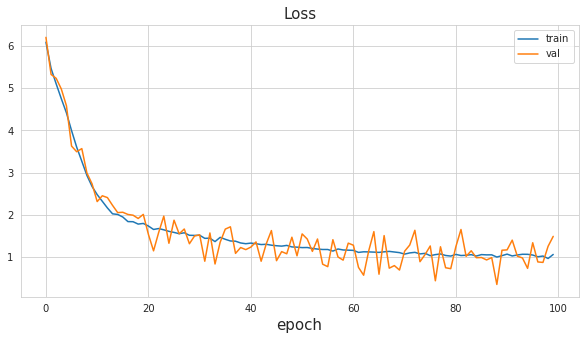

In [24]:
#model with batches rus-eng

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'])
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.NLLLoss(ignore_index=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                            factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'], scheduler)

Result is worse then I expected. Final learning rate is bigger then without scheduler and model stoped to improving.

Let's look at the translation result and calculate metric. 

In [ ]:
#from torchtext.data.metrics import bleu_score 

In [25]:
from nltk.translate.bleu_score import sentence_bleu

In [26]:
def evaluateRandomly(model, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        outputs=[]
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        
        input_tensor = tensorFromSentence(input_lang, pair[0], config['MAX_LENGTH'])
        input_len=torch.tensor([len(pair[0].split(' '))], dtype=torch.int64)
        target_tensor=tensorFromSentence(output_lang, pair[1], config['MAX_LENGTH'])
                
        output_words, _ = model(input_tensor.reshape(1,20), input_len, target_tensor.reshape(1,20), evalute=True)    
        
        result=output_words.argmax(2).detach()
        result=result.squeeze(0)
        
        for idx in range(result.shape[0]):
            tok=train_output_lang.index2word[result[idx].item()]
            if tok=='EOS':
              break
            outputs.append(tok) 
        #print(bleu_score(result.tolist(), target_tensor.tolist()))      
        output_sentence = ' '.join(outputs)
        print('<', output_sentence)
        print('')
        
        print('Blue score of this sentence  - ', sentence_bleu(outputs, pair[1].split(' ')))
        print('')
        print('======================================')

In [27]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=1)

> и боле же чьтите гость 
= особенно же почитаите гостя 
< особенно же почитаите гостя  

Blue score of this sentence  -  0



In [28]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang)

> и неправеднаго собрания
= и неправедного общества 
< и неправедного общества                 

Blue score of this sentence  -  0.7071067811865476

> югъ
= ужин
< ужин ужин

Blue score of this sentence  -  0

> господи мои и всехъ человѣкъ хоудьшiи да на толико дѣло доволенъ боудоу
= господь мои  и из всех людеи – самыи худшии  чтобы на такое великое дело быть способным 
< господь мои                  

Blue score of this sentence  -  0.47897362544357464

> и неправеднаго собрания
= и неправедного общества 
< и неправедного общества                 

Blue score of this sentence  -  0.7071067811865476

> ѿ дѣтьства бо ѥго нѣсть кто имъ оyдарилъ 
= с детства его никто не бросил оземь 
< с детства его никто не бросил оземь  его

Blue score of this sentence  -  0.5946035575013605

> и поносъ  и оукоризна сие съ любовию приимати 
= и поношение  и укоризну с любовью принимать 
< и поношение  и поношение  и поношение  и поношение  и поношение  и поношение  и поношение

Blue score of this sen

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [29]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang)

> брашномь
= едои
< ужин 

Blue score of this sentence  -  0

> конь на брани разоумѣетъ снѧгоу  дроугоу же въ печали добръ дроугъ пособитъ 
= сила коня познается в сражении  другу же в печали поможет добрыи друг 
< не не не не не не не не не не не не не не не не не не не не

Blue score of this sentence  -  0

> или добръ
= и богатого 
< верному другу на 

Blue score of this sentence  -  0

> или люди оправливати  или на ловъ ѣхати 
= или собираюсь творить суд между людеи  или ехать на охоту 
< и же       же   же 

Blue score of this sentence  -  0

> удолжися* остоя в городѣ и бѣ гладъ великъ
= затянулась осада города
< то   

Blue score of this sentence  -  0

> лисица  егда боудеть голодна 
= лисица  если голодна 
< уродливыи     

Blue score of this sentence  -  0

> плачющись подроуга своего и ктомоу не спрѧжетьсѧ сь имь николиже
= плача по своему супругу  что больше не соединится с ним никогда 
< которого             

Blue score of this sentence  -  0

> он же рече: кнѧже да иск

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Not good result. Let's try to use embeddings from Word2Vec model.

First clean memory

In [30]:
import gc

gc.collect()

219

Create word embadings using Word2Vec

In [31]:
from gensim.models import Word2Vec

collect all words from pairs

In [32]:
def collect_all_words(pairs, source=True):
  if source:
    sent=[pair[0] for pair in pairs]
  else:
    sent=[pair[1] for pair in pairs]
  all_words=  [[word for word in s.split(' ')] for s in sent]
  return all_words
all_src=  collect_all_words(train_pairs, source=True)
all_trg=  collect_all_words(train_pairs, source=False)

Create W2V models for source and target

In [33]:
w2v_model_src = Word2Vec(
    min_count=2,
    window=2,
    size=config['hidden_size'],
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)
w2v_model_trg = Word2Vec(
    min_count=2,
    window=2,
    size=config['hidden_size'],
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

Create vocabs for source and target

In [34]:
w2v_model_src.build_vocab(all_src)
w2v_model_trg.build_vocab(all_trg)

Train models

In [35]:
w2v_model_src.train(all_src, total_examples=w2v_model_src.corpus_count, epochs=30, report_delay=1)

(1252, 39180)

In [36]:
w2v_model_trg.train(all_src, total_examples=w2v_model_trg.corpus_count, epochs=30, report_delay=1)

(532, 39180)

Save memory

In [37]:
w2v_model_src.init_sims(replace=True)
w2v_model_trg.init_sims(replace=True)

Check numbers of words in vocabularies

In [38]:
len(w2v_model_src.wv.vocab), len(w2v_model_trg.wv.vocab)

(96, 113)

Create embaddings for the words in vocabularies and out of vocabularies

In [39]:
def get_weights(word2vec, vocab):
  mean = word2vec.wv.vectors.mean(1).mean()
  std = word2vec.wv.vectors.std(1).mean()
  vec_size = word2vec.wv.vector_size
  weights = torch.zeros((len(vocab)+2, vec_size))
  for i, word in enumerate(vocab):
    try:
      weights[i] = torch.tensor(word2vec.wv[word])
    except KeyError:
        weights[i] = torch.randn(vec_size) * std + mean
  weights[len(vocab)]  =torch.zeros(vec_size)  
  weights[len(vocab)]  =torch.ones(vec_size)  
  return   weights    

In [40]:
weights_src=get_weights(w2v_model_src, train_input_lang.word2index.keys())
weights_trg=get_weights(w2v_model_trg, train_output_lang.word2index.keys())

Check shape of weights

In [41]:
weights_src.shape, weights_trg.shape

(torch.Size([776, 256]), torch.Size([744, 256]))

Create embaddings

In [42]:
embedding_src = nn.Embedding.from_pretrained(weights_src)
embedding_trg = nn.Embedding.from_pretrained(weights_trg)

Check embeddings shapes

In [43]:
embedding_src, embedding_trg

(Embedding(776, 256), Embedding(744, 256))

I use these embeddings in model. Model needs some changes, to make model use given embeddings or create embeddings if not given.

train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

epochs:   1%|          | 1/100 [00:04<06:42,  4.06s/it]

Epoch train loss 6.232850098609925
Epoch val_loss 5.962906837463379



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 24.93it/s]

Epoch 00012: reducing learning rate of group 0 to 9.5000e-04.



epochs:   2%|▏         | 2/100 [00:08<06:41,  4.10s/it]

Epoch train loss 5.665616917610168
Epoch val_loss 5.912442684173584



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

epochs:   3%|▎         | 3/100 [00:12<06:35,  4.08s/it]

Epoch 00023: reducing learning rate of group 0 to 9.0250e-04.
Epoch train loss 5.569531869888306
Epoch val_loss 5.846585273742676



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:   4%|▍         | 4/100 [00:16<06:29,  4.06s/it]

Epoch 00034: reducing learning rate of group 0 to 8.5737e-04.
Epoch train loss 5.492476534843445
Epoch val_loss 5.6505126953125



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

epochs:   5%|▌         | 5/100 [00:20<06:25,  4.06s/it]

Epoch 00045: reducing learning rate of group 0 to 8.1451e-04.
Epoch train loss 5.45218858718872
Epoch val_loss 5.282711029052734



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.59it/s]

epochs:   6%|▌         | 6/100 [00:24<06:19,  4.04s/it]

Epoch train loss 5.38104784488678
Epoch val_loss 5.898865222930908



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.45it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 25.95it/s]

Epoch 00056: reducing learning rate of group 0 to 7.7378e-04.



epochs:   7%|▋         | 7/100 [00:28<06:16,  4.05s/it]

Epoch train loss 5.335405230522156
Epoch val_loss 5.720124244689941



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 24.14it/s]

Epoch 00067: reducing learning rate of group 0 to 7.3509e-04.



epochs:   8%|▊         | 8/100 [00:32<06:12,  4.05s/it]

Epoch train loss 5.251627850532532
Epoch val_loss 5.4190497398376465



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:   9%|▉         | 9/100 [00:36<06:08,  4.05s/it]

Epoch 00078: reducing learning rate of group 0 to 6.9834e-04.
Epoch train loss 5.173185968399048
Epoch val_loss 5.399786949157715



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.54it/s]

epochs:  10%|█         | 10/100 [00:41<06:26,  4.30s/it]

Epoch 00089: reducing learning rate of group 0 to 6.6342e-04.
Epoch train loss 5.115388298034668
Epoch val_loss 5.278872013092041



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]

epochs:  11%|█         | 11/100 [00:45<06:27,  4.35s/it]

Epoch train loss 4.993729043006897
Epoch val_loss 5.272590160369873



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 26.86it/s]

Epoch 00100: reducing learning rate of group 0 to 6.3025e-04.



epochs:  12%|█▏        | 12/100 [00:49<06:15,  4.27s/it]

Epoch train loss 4.913683295249939
Epoch val_loss 4.786532878875732



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 23.68it/s]

Epoch 00111: reducing learning rate of group 0 to 5.9874e-04.



epochs:  13%|█▎        | 13/100 [00:53<06:05,  4.20s/it]

Epoch train loss 4.809280490875244
Epoch val_loss 4.946681499481201



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.20it/s]

Epoch 00122: reducing learning rate of group 0 to 5.6880e-04.
Epoch train loss 4.766475343704224
Epoch val_loss 4.974249839782715



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.57it/s]

epochs:  15%|█▌        | 15/100 [01:02<05:50,  4.12s/it]

Epoch 00133: reducing learning rate of group 0 to 5.4036e-04.
Epoch train loss 4.648500680923462
Epoch val_loss 4.515028953552246



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.56it/s]

epochs:  16%|█▌        | 16/100 [01:06<05:43,  4.09s/it]

Epoch 00144: reducing learning rate of group 0 to 5.1334e-04.
Epoch train loss 4.5421709537506105
Epoch val_loss 4.40587043762207



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  17%|█▋        | 17/100 [01:10<05:39,  4.09s/it]

Epoch train loss 4.420194339752197
Epoch val_loss 4.3192830085754395



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.73it/s]

Epoch 00155: reducing learning rate of group 0 to 4.8767e-04.



epochs:  18%|█▊        | 18/100 [01:14<05:35,  4.09s/it]

Epoch train loss 4.302596271038055
Epoch val_loss 4.548624515533447



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.95it/s]

Epoch 00166: reducing learning rate of group 0 to 4.6329e-04.



epochs:  19%|█▉        | 19/100 [01:18<05:32,  4.10s/it]

Epoch train loss 4.22540693283081
Epoch val_loss 4.153163433074951



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.49it/s]

epochs:  20%|██        | 20/100 [01:22<05:27,  4.10s/it]

Epoch 00177: reducing learning rate of group 0 to 4.4013e-04.
Epoch train loss 4.136101710796356
Epoch val_loss 4.4221882820129395



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

epochs:  21%|██        | 21/100 [01:26<05:23,  4.09s/it]

Epoch 00188: reducing learning rate of group 0 to 4.1812e-04.
Epoch train loss 4.060520136356354
Epoch val_loss 3.8945796489715576



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

epochs:  22%|██▏       | 22/100 [01:30<05:19,  4.10s/it]

Epoch train loss 3.953496813774109
Epoch val_loss 4.000975608825684



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 25.20it/s]

Epoch 00199: reducing learning rate of group 0 to 3.9721e-04.



epochs:  23%|██▎       | 23/100 [01:34<05:14,  4.09s/it]

Epoch train loss 3.9187121868133543
Epoch val_loss 3.7571964263916016



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 19.35it/s]

Epoch 00210: reducing learning rate of group 0 to 3.7735e-04.



epochs:  24%|██▍       | 24/100 [01:38<05:12,  4.12s/it]

Epoch train loss 3.878494346141815
Epoch val_loss 4.0346999168396



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.40it/s]

epochs:  25%|██▌       | 25/100 [01:43<05:09,  4.13s/it]

Epoch 00221: reducing learning rate of group 0 to 3.5849e-04.
Epoch train loss 3.775399994850159
Epoch val_loss 3.6999869346618652



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

epochs:  26%|██▌       | 26/100 [01:47<05:07,  4.16s/it]

Epoch 00232: reducing learning rate of group 0 to 3.4056e-04.
Epoch train loss 3.705232226848602
Epoch val_loss 3.853238582611084



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]

epochs:  27%|██▋       | 27/100 [01:51<05:03,  4.16s/it]

Epoch 00243: reducing learning rate of group 0 to 3.2353e-04.
Epoch train loss 3.622113275527954
Epoch val_loss 3.645966053009033



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

epochs:  28%|██▊       | 28/100 [01:55<04:58,  4.15s/it]

Epoch train loss 3.5592219710350035
Epoch val_loss 3.7541942596435547



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.53it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 23.14it/s]

Epoch 00254: reducing learning rate of group 0 to 3.0736e-04.



epochs:  29%|██▉       | 29/100 [01:59<04:52,  4.12s/it]

Epoch train loss 3.484741997718811
Epoch val_loss 2.9165210723876953



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.47it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 24.52it/s]

Epoch 00265: reducing learning rate of group 0 to 2.9199e-04.


epochs:  30%|███       | 30/100 [02:03<04:47,  4.11s/it]

Epoch train loss 3.434755635261536
Epoch val_loss 3.5134775638580322



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]

epochs:  31%|███       | 31/100 [02:07<04:44,  4.12s/it]

Epoch 00276: reducing learning rate of group 0 to 2.7739e-04.
Epoch train loss 3.390606713294983
Epoch val_loss 3.441859483718872



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.51it/s]

epochs:  32%|███▏      | 32/100 [02:11<04:39,  4.11s/it]

Epoch 00287: reducing learning rate of group 0 to 2.6352e-04.
Epoch train loss 3.376949203014374
Epoch val_loss 3.348623514175415



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.55it/s]

epochs:  33%|███▎      | 33/100 [02:16<04:34,  4.10s/it]

Epoch train loss 3.2920586228370667
Epoch val_loss 3.5605297088623047



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.15it/s]

Epoch 00298: reducing learning rate of group 0 to 2.5034e-04.



epochs:  34%|███▍      | 34/100 [02:20<04:30,  4.10s/it]

Epoch train loss 3.2566317319869995
Epoch val_loss 3.5251107215881348



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 19.22it/s]

Epoch 00309: reducing learning rate of group 0 to 2.3783e-04.



epochs:  35%|███▌      | 35/100 [02:24<04:29,  4.15s/it]

Epoch train loss 3.204924237728119
Epoch val_loss 3.0412817001342773



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.41it/s]

epochs:  36%|███▌      | 36/100 [02:28<04:24,  4.13s/it]

Epoch 00320: reducing learning rate of group 0 to 2.2594e-04.
Epoch train loss 3.167936050891876
Epoch val_loss 3.332160711288452



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

epochs:  37%|███▋      | 37/100 [02:32<04:18,  4.11s/it]

Epoch 00331: reducing learning rate of group 0 to 2.1464e-04.
Epoch train loss 3.131254553794861
Epoch val_loss 2.9169065952301025



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.50it/s]

epochs:  38%|███▊      | 38/100 [02:36<04:14,  4.10s/it]

Epoch 00342: reducing learning rate of group 0 to 2.0391e-04.
Epoch train loss 3.079673111438751
Epoch val_loss 3.056800603866577



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

epochs:  39%|███▉      | 39/100 [02:40<04:10,  4.10s/it]

Epoch train loss 3.047115170955658
Epoch val_loss 2.9281935691833496



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.48it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.59it/s]

Epoch 00353: reducing learning rate of group 0 to 1.9371e-04.



epochs:  40%|████      | 40/100 [02:44<04:06,  4.11s/it]

Epoch train loss 3.003963661193848
Epoch val_loss 2.947458267211914



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 24.64it/s]

Epoch 00364: reducing learning rate of group 0 to 1.8403e-04.


epochs:  41%|████      | 41/100 [02:48<04:02,  4.12s/it]

Epoch train loss 2.9966299533843994
Epoch val_loss 3.110564947128296



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]

epochs:  42%|████▏     | 42/100 [02:53<03:59,  4.13s/it]

Epoch 00375: reducing learning rate of group 0 to 1.7482e-04.
Epoch train loss 2.9723557114601133
Epoch val_loss 3.051964044570923



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]

epochs:  43%|████▎     | 43/100 [02:57<03:55,  4.14s/it]

Epoch 00386: reducing learning rate of group 0 to 1.6608e-04.
Epoch train loss 2.935178017616272
Epoch val_loss 2.632939338684082



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.54it/s]

epochs:  44%|████▍     | 44/100 [03:01<03:49,  4.10s/it]

Epoch train loss 2.9137918829917906
Epoch val_loss 2.8969757556915283



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 28.63it/s]


Epoch 00397: reducing learning rate of group 0 to 1.5778e-04.


epochs:  45%|████▌     | 45/100 [03:05<03:45,  4.10s/it]

Epoch train loss 2.896098053455353
Epoch val_loss 2.8974039554595947



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.42it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.56it/s]

Epoch 00408: reducing learning rate of group 0 to 1.4989e-04.



epochs:  46%|████▌     | 46/100 [03:09<03:42,  4.13s/it]

Epoch train loss 2.869272220134735
Epoch val_loss 2.996436357498169



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.39it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.73it/s]

Epoch 00419: reducing learning rate of group 0 to 1.4240e-04.
Epoch train loss 2.844003963470459
Epoch val_loss 2.600771427154541



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]

epochs:  48%|████▊     | 48/100 [03:17<03:35,  4.15s/it]

Epoch 00430: reducing learning rate of group 0 to 1.3528e-04.
Epoch train loss 2.8314059257507322
Epoch val_loss 3.040600538253784



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.43it/s]

epochs:  49%|████▉     | 49/100 [03:22<03:31,  4.14s/it]

Epoch 00441: reducing learning rate of group 0 to 1.2851e-04.
Epoch train loss 2.8082655549049376
Epoch val_loss 2.702169418334961



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]

epochs:  50%|█████     | 50/100 [03:26<03:28,  4.16s/it]

Epoch train loss 2.7753475427627565
Epoch val_loss 2.78666615486145



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.51it/s]

Epoch 00452: reducing learning rate of group 0 to 1.2209e-04.



epochs:  51%|█████     | 51/100 [03:30<03:25,  4.19s/it]

Epoch train loss 2.7718210577964784
Epoch val_loss 2.861717462539673



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.44it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 23.78it/s]

Epoch 00463: reducing learning rate of group 0 to 1.1598e-04.


epochs:  52%|█████▏    | 52/100 [03:34<03:20,  4.17s/it]

Epoch train loss 2.761623215675354
Epoch val_loss 2.757037401199341



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  53%|█████▎    | 53/100 [03:38<03:17,  4.20s/it]

Epoch 00474: reducing learning rate of group 0 to 1.1018e-04.
Epoch train loss 2.754259943962097
Epoch val_loss 2.6137046813964844



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.37it/s]

epochs:  54%|█████▍    | 54/100 [03:43<03:12,  4.19s/it]

Epoch 00485: reducing learning rate of group 0 to 1.0467e-04.
Epoch train loss 2.741040349006653
Epoch val_loss 2.7938790321350098



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  55%|█████▌    | 55/100 [03:47<03:10,  4.22s/it]

Epoch train loss 2.7235012888908385
Epoch val_loss 2.6291298866271973



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 24.51it/s]

Epoch 00496: reducing learning rate of group 0 to 9.9440e-05.



epochs:  56%|█████▌    | 56/100 [03:51<03:05,  4.23s/it]

Epoch train loss 2.734105980396271
Epoch val_loss 2.637543201446533



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.30it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.18it/s]

Epoch 00507: reducing learning rate of group 0 to 9.4468e-05.



epochs:  57%|█████▋    | 57/100 [03:55<03:01,  4.23s/it]

Epoch train loss 2.7226072669029238
Epoch val_loss 2.5968616008758545



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.31it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.95it/s]

Epoch 00518: reducing learning rate of group 0 to 8.9745e-05.
Epoch train loss 2.697519338130951
Epoch val_loss 2.8607447147369385



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]

epochs:  59%|█████▉    | 59/100 [04:04<02:54,  4.25s/it]

Epoch 00529: reducing learning rate of group 0 to 8.5258e-05.
Epoch train loss 2.6983991384506227
Epoch val_loss 2.697030544281006



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.29it/s]

epochs:  60%|██████    | 60/100 [04:08<02:50,  4.25s/it]

Epoch 00540: reducing learning rate of group 0 to 8.0995e-05.
Epoch train loss 2.6815011262893678
Epoch val_loss 2.941131830215454



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.36it/s]

epochs:  61%|██████    | 61/100 [04:12<02:45,  4.24s/it]

Epoch train loss 2.674751031398773
Epoch val_loss 2.9237306118011475



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.34it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 21.59it/s]

Epoch 00551: reducing learning rate of group 0 to 7.6945e-05.



epochs:  62%|██████▏   | 62/100 [04:17<02:40,  4.24s/it]

Epoch train loss 2.6589189171791077
Epoch val_loss 2.85327410697937



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.69it/s]

Epoch 00562: reducing learning rate of group 0 to 7.3098e-05.



epochs:  63%|██████▎   | 63/100 [04:21<02:36,  4.24s/it]

Epoch train loss 2.651942718029022
Epoch val_loss 2.4138095378875732



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.28it/s]

epochs:  64%|██████▍   | 64/100 [04:25<02:32,  4.25s/it]

Epoch 00573: reducing learning rate of group 0 to 6.9443e-05.
Epoch train loss 2.647328329086304
Epoch val_loss 2.714447259902954



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.25it/s]

epochs:  65%|██████▌   | 65/100 [04:29<02:28,  4.25s/it]

Epoch 00584: reducing learning rate of group 0 to 6.5971e-05.
Epoch train loss 2.639644134044647
Epoch val_loss 2.5814194679260254



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.27it/s]

epochs:  66%|██████▌   | 66/100 [04:34<02:24,  4.25s/it]

Epoch train loss 2.6238223791122435
Epoch val_loss 2.5558083057403564



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

validation sample batches:  56%|█████▌    | 5/9 [00:00<00:00, 20.07it/s]

Epoch 00595: reducing learning rate of group 0 to 6.2672e-05.



epochs:  67%|██████▋   | 67/100 [04:38<02:21,  4.29s/it]

Epoch train loss 2.6284104108810427
Epoch val_loss 2.5317928791046143



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 22.04it/s]

Epoch 00606: reducing learning rate of group 0 to 5.9539e-05.



epochs:  68%|██████▊   | 68/100 [04:42<02:17,  4.31s/it]

Epoch train loss 2.6027975201606752
Epoch val_loss 2.1652722358703613



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.02it/s]

validation sample batches: 100%|██████████| 9/9 [00:00<00:00, 22.34it/s]

Epoch 00617: reducing learning rate of group 0 to 5.6562e-05.
Epoch train loss 2.608799362182617
Epoch val_loss 2.5975818634033203



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.15it/s]

epochs:  70%|███████   | 70/100 [04:51<02:10,  4.36s/it]

Epoch 00628: reducing learning rate of group 0 to 5.3734e-05.
Epoch train loss 2.5968507170677184
Epoch val_loss 2.7502200603485107



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]

epochs:  71%|███████   | 71/100 [04:56<02:06,  4.36s/it]

Epoch 00639: reducing learning rate of group 0 to 5.1047e-05.
Epoch train loss 2.5969340085983275
Epoch val_loss 3.0798773765563965



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

epochs:  72%|███████▏  | 72/100 [05:00<02:01,  4.33s/it]

Epoch train loss 2.5778783798217773
Epoch val_loss 2.4500229358673096



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.42it/s]

Epoch 00650: reducing learning rate of group 0 to 4.8495e-05.



epochs:  73%|███████▎  | 73/100 [05:04<01:56,  4.32s/it]

Epoch train loss 2.566171872615814
Epoch val_loss 2.2404189109802246



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 21.32it/s]

Epoch 00661: reducing learning rate of group 0 to 4.6070e-05.



epochs:  74%|███████▍  | 74/100 [05:08<01:52,  4.33s/it]

Epoch train loss 2.5741878271102907
Epoch val_loss 2.6794381141662598



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]

epochs:  75%|███████▌  | 75/100 [05:13<01:47,  4.32s/it]

Epoch 00672: reducing learning rate of group 0 to 4.3766e-05.
Epoch train loss 2.5693230867385863
Epoch val_loss 2.7364792823791504



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.16it/s]

epochs:  76%|███████▌  | 76/100 [05:17<01:43,  4.33s/it]

Epoch 00683: reducing learning rate of group 0 to 4.1578e-05.
Epoch train loss 2.5558081746101378
Epoch val_loss 2.6182613372802734



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.20it/s]

epochs:  77%|███████▋  | 77/100 [05:21<01:39,  4.32s/it]

Epoch train loss 2.5401906728744508
Epoch val_loss 2.6203455924987793



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

validation sample batches:  33%|███▎      | 3/9 [00:00<00:00, 26.75it/s]

Epoch 00694: reducing learning rate of group 0 to 3.9499e-05.



epochs:  78%|███████▊  | 78/100 [05:26<01:35,  4.35s/it]

Epoch train loss 2.5437305331230164
Epoch val_loss 2.6271634101867676



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 18.66it/s]

Epoch 00705: reducing learning rate of group 0 to 3.7524e-05.



epochs:  79%|███████▉  | 79/100 [05:30<01:32,  4.39s/it]

Epoch train loss 2.546686387062073
Epoch val_loss 2.7006564140319824



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 18.44it/s]

Epoch 00716: reducing learning rate of group 0 to 3.5648e-05.


epochs:  80%|████████  | 80/100 [05:35<01:27,  4.39s/it]

Epoch train loss 2.538490724563599
Epoch val_loss 2.635861396789551



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  81%|████████  | 81/100 [05:39<01:24,  4.44s/it]

Epoch 00727: reducing learning rate of group 0 to 3.3866e-05.
Epoch train loss 2.5342486023902895
Epoch val_loss 2.319331645965576



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.06it/s]

epochs:  82%|████████▏ | 82/100 [05:44<01:20,  4.45s/it]

Epoch 00738: reducing learning rate of group 0 to 3.2172e-05.
Epoch train loss 2.533374071121216
Epoch val_loss 2.434891700744629



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]

epochs:  83%|████████▎ | 83/100 [05:48<01:16,  4.49s/it]

Epoch train loss 2.532711851596832
Epoch val_loss 2.3553361892700195



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 17.97it/s]

Epoch 00749: reducing learning rate of group 0 to 3.0564e-05.



epochs:  84%|████████▍ | 84/100 [05:53<01:12,  4.52s/it]

Epoch train loss 2.5188261032104493
Epoch val_loss 2.449437141418457



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 20.20it/s]

Epoch 00760: reducing learning rate of group 0 to 2.9035e-05.


epochs:  85%|████████▌ | 85/100 [05:57<01:07,  4.53s/it]

Epoch train loss 2.518622076511383
Epoch val_loss 2.5887763500213623



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]

epochs:  86%|████████▌ | 86/100 [06:02<01:02,  4.50s/it]

Epoch 00771: reducing learning rate of group 0 to 2.7584e-05.
Epoch train loss 2.5211593747138976
Epoch val_loss 2.487093687057495



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.09it/s]

epochs:  87%|████████▋ | 87/100 [06:06<00:58,  4.48s/it]

Epoch 00782: reducing learning rate of group 0 to 2.6205e-05.
Epoch train loss 2.4975530385971068
Epoch val_loss 2.343498945236206



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.03it/s]

epochs:  88%|████████▊ | 88/100 [06:11<00:53,  4.47s/it]

Epoch train loss 2.518382358551025
Epoch val_loss 2.4106903076171875



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

validation sample batches:  44%|████▍     | 4/9 [00:00<00:00, 17.76it/s]

Epoch 00793: reducing learning rate of group 0 to 2.4894e-05.



epochs:  89%|████████▉ | 89/100 [06:15<00:49,  4.50s/it]

Epoch train loss 2.509967625141144
Epoch val_loss 2.5507068634033203



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.84it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 18.78it/s]

Epoch 00804: reducing learning rate of group 0 to 2.3650e-05.



epochs:  90%|█████████ | 90/100 [06:20<00:45,  4.55s/it]

Epoch train loss 2.5168174386024473
Epoch val_loss 2.3212392330169678



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.94it/s]

validation sample batches:  89%|████████▉ | 8/9 [00:00<00:00, 18.85it/s]

Epoch 00815: reducing learning rate of group 0 to 2.2467e-05.


epochs:  91%|█████████ | 91/100 [06:25<00:40,  4.55s/it]

Epoch train loss 2.5038936018943785
Epoch val_loss 2.701245069503784



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.83it/s]

epochs:  92%|█████████▏| 92/100 [06:29<00:36,  4.59s/it]

Epoch 00826: reducing learning rate of group 0 to 2.1344e-05.
Epoch train loss 2.503690314292908
Epoch val_loss 2.4858553409576416



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.96it/s]

epochs:  93%|█████████▎| 93/100 [06:34<00:32,  4.58s/it]

Epoch 00837: reducing learning rate of group 0 to 2.0277e-05.
Epoch train loss 2.4903087615966797
Epoch val_loss 2.5672311782836914



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s]

epochs:  94%|█████████▍| 94/100 [06:38<00:27,  4.63s/it]

Epoch train loss 2.5216463923454286
Epoch val_loss 2.3047845363616943



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.87it/s]

validation sample batches:  67%|██████▋   | 6/9 [00:00<00:00, 20.61it/s]

Epoch 00848: reducing learning rate of group 0 to 2.0000e-05.



epochs:  95%|█████████▌| 95/100 [06:43<00:23,  4.62s/it]

Epoch train loss 2.4918086767196654
Epoch val_loss 2.5774614810943604



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.81it/s]

epochs:  96%|█████████▌| 96/100 [06:48<00:18,  4.64s/it]

Epoch train loss 2.5079629898071287
Epoch val_loss 2.4038920402526855



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.93it/s]

epochs:  97%|█████████▋| 97/100 [06:52<00:13,  4.62s/it]

Epoch train loss 2.5076592206954955
Epoch val_loss 2.6170294284820557



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  5.00it/s]

epochs:  98%|█████████▊| 98/100 [06:57<00:09,  4.58s/it]

Epoch train loss 2.488806903362274
Epoch val_loss 2.577265977859497



train sample batches: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]

epochs:  99%|█████████▉| 99/100 [07:01<00:04,  4.57s/it]

Epoch train loss 2.4970734834671022
Epoch val_loss 2.629248857498169



train sample batches: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]

epochs: 100%|██████████| 100/100 [07:06<00:00,  4.26s/it]


Epoch train loss 2.4828266978263853
Epoch val_loss 2.701979637145996


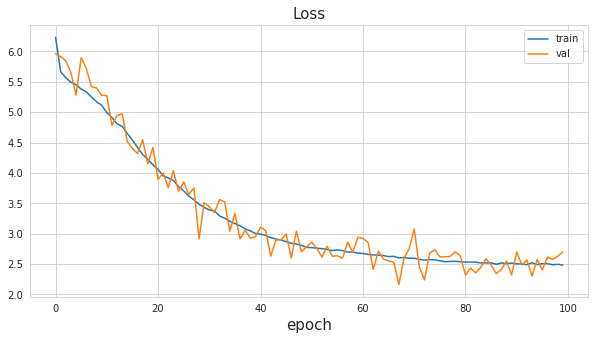

In [44]:
#model with batches old rus emb W2v

encoder1 = EncoderRNN(train_input_lang.n_words, config['hidden_size'], embedding_src)
attn_decoder1 = AttnDecoderRNN(config['hidden_size'], train_output_lang.n_words, config['MAX_LENGTH'], dropout_p=0.1, embedding=embedding_trg)
model=TONModel(encoder1, attn_decoder1, config['teacher_forcing_ratio']).to(device)

optimizer = optim.Adam(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',\
                            factor=0.95, threshold=0.1, min_lr=2e-5, verbose=True)
criterion = nn.NLLLoss(ignore_index=0)
train_modelIters(model, optimizer, train_loader, test_loader, criterion, config['num_epochs'], scheduler)

Results is worser then with out embeddings. Let's change loss function.

In [46]:
model_1=torch.load('/content/best_model.pt')

In [48]:
evaluateRandomly(model, train_pairs, train_input_lang, train_output_lang, n=10)

> мyжь книжьнъ  а пьянчивъ не можеть направитисѧ на истиннy спасениа 
= человек ученыи  но пьяница  не может направить себя на путь спасения 
< человек ученыи                  

Blue score of this sentence  -  0

> аще то сѧ обое мьнитъ въ человѣцѣ  то яко очи обѣ въ тѣлѣ свершено имyще глядѧть 
= если же и то и другое есть в человеке  то это словно два глаза в теле  глядящие зорко 
< то и и же и же и и и и  и и и и и и и  и

Blue score of this sentence  -  0.4671379777282001

> азъ же двигъсѧ и обрѣтохъ себе здрава 
= же пошевелился и почувствовал себя здоровым 
< и пошевелился                  

Blue score of this sentence  -  0.34718201116725705

> рече паки: достоить инокy  въ общемъ житии живyщy  ѥдино брашно оставляти и глаголати: сие часть христа моего 
= и еще он сказал: иноку  живущему в общежительном   следует часть пищи оставлять и говорить: это часть христа моего 
< и еще               еще   

Blue score of this sentence  -  0.46173663094410267

> волокитою оуморитъ 
= томи

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Not bad for train data. Let's look at test data.

In [50]:
evaluateRandomly(model, test_pairs, test_input_lang, test_output_lang, n=5)

> плѣненыя же дyшею оплѣнити къ благочестию 
= плененных душои вернуть к благочестию 
< а                   

Blue score of this sentence  -  0

> или добръ
= и богатого 
< ужин   я

Blue score of this sentence  -  0.5444460596606694

> дъва рождениѣ соуть 
= то это два рождения 
< однажды храбрость храбрость храбрость храбрость гораздо

Blue score of this sentence  -  0

> съ многою ӡълобою вьсѧ испровращающа 
= со многои злобои все ниспровергающего 
< и же                  

Blue score of this sentence  -  0

> и мнози отъ нихъ крестишасѧ  тогда и отьца пафнyтия дѣдъ крестисѧ и нареченъ бысть мартинъ 
= и многие из них крестились  тогда и дед отца пафнутия крестился и был назван мартыном
< но этого этого этого этого этого этого этого этого этого этого этого этого этого этого этого этого

Blue score of this sentence  -  0



/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [51]:
def evaluate(model, pairs, input_lang=train_input_lang, output_lang=train_output_lang):
    outputs=[]        
    input_tensor = tensorFromSentence(input_lang, pairs[0], config['MAX_LENGTH'])
    input_len=torch.tensor([len(pairs[0].split(' '))], dtype=torch.int64)
    target_tensor=tensorFromSentence(output_lang, pairs[1], config['MAX_LENGTH'])
                
    output_words, attention = model(input_tensor.reshape(1,20), input_len, target_tensor.reshape(1,20), evalute=True)    
        
    result=output_words.argmax(2).detach()
    result=result.squeeze(0)
        
    for idx in range(result.shape[0]):
        tok=train_output_lang.index2word[result[idx].item()]
        if tok=='EOS':
          break
        outputs.append(tok) 
             
        output_sentence = ' '.join(outputs)
    return    outputs,  attention

In [73]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze().cpu().detach()
    a=torch.zeros(len(attention), len(attention))
    for idx in range(len(attention)):
      a[idx,idx]=attention[idx]
    cax = ax.matshow(a.numpy(), cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
    
    ax.set_xticklabels(x_ticks, rotation=90)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model, input_sentence)
    print('input =', input_sentence[0])
    print('output =', ' '.join(output_words))
    attentions=attentions.detach()
    
    display_attention(input_sentence[0].split(' '), output_words, attentions)



input = и та чьсть бyдетъ съ великимъ беӡчьстиемъ и со оукоризною 
output = та стыдом бесчестием бесчестием стыдом бесчестием честь честь бесчестием


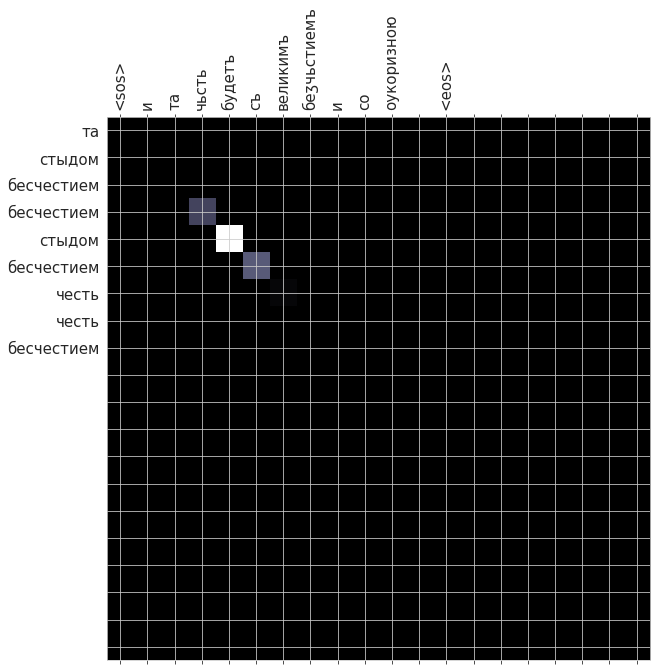

In [80]:
evaluateAndShowAttention(random.choice(train_pairs))

